#Project
## CQI Data Analysis

####Loading the Data

In [ ]:
library(tidyverse)
library(ggplot2)
library(dplyr)
install.packages("randomForest")
library("randomForest")
install.packages("gbm")
library(gbm)
install.packages("corrplot")
library(corrplot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



For Project 2, I chose to work on a new dataset focused on the quality of coffee. As a passive but consistent coffee drinker, I enjoy tasting different flavors at various coffee shops nearby. This personal interest made the dataset particularly appealing to me.

Upon reviewing the dataset on Kaggle, I immediately identified "flavor" as my target (response) variable. This led me to ask several questions: What factors influence coffee flavor? Which factor has the strongest impact? How should I interpret the numerical values in the dataset? Through data analysis and testing several regression models, I hoped to uncover these answers. Since the response variable is numerical, this project primarily involved the application of regression models.

Beyond my curiosity, understanding what contributes to coffee flavor has broader market implications. In the competitive coffee industry, knowing the key factors that drive flavor quality can help coffee producers, sellers, and even enthusiasts make informed decisions. Whether improving cultivation practices, refining roasting techniques, or marketing specialty coffees, these insights hold value. Through this sellers can increase their revenue, differntiate their brand, and enhance customer satisfaction.

In [ ]:
site<-"https://github.com/dmembreno/"
repo <- "MATH331/raw/refs/heads/main/"
the_file <- "Coffee_Qlty.csv"
df <- read.csv(paste0(c(site,repo,the_file),collapse=""))

As I mentioned earlier, this dataset was found on Kaggle, and the data itself is sourced from the Coffee Quality Institute, a nonprofit organization dedicated to coffee enthusiasts. They maintain an extensive coffee database with a wide range of information including tasting profiles, cultivation methods, processing techniques, and quality scores.

https://www.coffeeinstitute.org/

https://www.kaggle.com/datasets/adampq/coffee-quality-with-locations-of-origin?select=Coffee_Qlty.csv

In [ ]:
head(df,3)

,REC_ID,Species,Continent.of.Origin,Country.of.Origin,Harvest.Year,Expiration,Variety,Color,Processing.Method,Aroma,⋯,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Moisture,Quakers,Category.One.Defects,Category.Two.Defects
,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0,Arabica,Africa,Ethiopia,2014,04/03/16,,Green,Washed / Wet,8.67,⋯,8.75,8.50,8.42,10,10,10,0.12,0,0,0
2,1,Arabica,Africa,Ethiopia,2014,04/03/16,Other,Green,Washed / Wet,8.75,⋯,8.58,8.42,8.42,10,10,10,0.12,0,0,1
3,2,Arabica,North America,Guatemala,NA,05/31/11,Bourbon,,,8.42,⋯,8.42,8.33,8.42,10,10,10,0.00,0,0,0


In [ ]:
df <- subset(df, select = -REC_ID)

I removed the REC_ID variable because it is not useful.

In [ ]:
df <- df %>%
  rename( Minor_Defects=Category.One.Defects,Major_Defects=Category.Two.Defects)

These variables were renamed for clarity we removed all NA values in df as well as duplicated ones.

In [ ]:
df <- na.omit(df)

In [ ]:
sum(duplicated(df))
df <- df[!duplicated(df), ]

[1] 1

To remove outliers from the numeric columns, we applied a process using Z-scores. Z-scores are calculated by subtracting the mean of the dataset from each data point and then dividing the result by the standard deviation. This gives us a measure of how far each value is from the mean, expressed in terms of standard deviations. By removing any numeric values with a Z-score greater than 3 or less than -3, we effectively eliminate extreme outliers that fall far from the mean. We doubled this process here and renamed our doubly cleaned dataset to df2. Compared to the original dataset, df2 account for around 75% of the original data which is more than enough to work with.

In [ ]:
numeric_columns <- sapply(df, is.numeric)  # Identify numeric columns
numeric_df <- df[, numeric_columns]  # Select only numeric columns

In [ ]:
# Calculate Z-scores for each numeric column
z_scores <- as.data.frame(scale(numeric_df))  # This standardizes the columns and gives the Z-scores
# Find rows where any column has a Z-score > 3 or < -3
outliers_rows <- apply(z_scores, 1, function(x) any(abs(x) > 3))

# Filters out the rows with Z-scores > 3 or < -3
df_cleaned <- df[!outliers_rows, ]

nrow(df_cleaned)


[1] 1134

In [ ]:
z_scores_cleaned <- as.data.frame(scale(df_cleaned[, numeric_columns]))
outliers_cleaned <- apply(z_scores_cleaned, 1, function(x) any(abs(x) > 3))
cat("Rows with outliers in cleaned dataset: ", sum(outliers_cleaned), "\n")

df_doubleclean <- df_cleaned[!outliers_cleaned,]

Rows with outliers in cleaned dataset:  175 


In [ ]:
z_scores_double <- as.data.frame(scale(df_doubleclean[, numeric_columns]))

outlier_double <- apply(z_scores_double,1,function(x) any(abs(x)>3))
cat("Rows with outlier in double cleaned dataset: ", sum (outlier_double))

Rows with outlier in double cleaned dataset:  NA

In [ ]:
cat("Percentage of data retained: ",nrow(df_doubleclean)/nrow(df)*100,"%")

Percentage of data retained:  75.03912 %

In [ ]:
df2 <- df_doubleclean

In [ ]:
unique(df2$Processing.Method)

[1] "Washed / Wet"              ""                         
[3] "Natural / Dry"             "Pulped natural / honey"   
[5] "Semi-washed / Semi-pulped" "Other"

In [ ]:
# Remove rows where 'Processing.Method' is empty
df2 <- df2[df2$`Processing.Method` != '', ]

In [ ]:
unique(df2$Color)

[1] ""             "Green"        "Bluish-Green" "Blue-Green"   "None"

In [ ]:
df2 <- df2[df2$`Color` != '', ]

In [ ]:
unique(df2$Processing.Method)

[1] "Washed / Wet"              "Natural / Dry"            
[3] "Pulped natural / honey"    "Semi-washed / Semi-pulped"
[5] "Other"

In [ ]:
cat("Percentage of data retained: ",nrow(df2)/nrow(df)*100)

Percentage of data retained:  63.84977

In [ ]:
sum(is.na(df2))

[1] 0

So far we have removed all NA values, cleaned our data from extreme values, and removed all duplicated rows. We are now ready to plot.

### Data Dictionary

| **Variable Name**      | **Description**                                                                                              |
|------------------------|--------------------------------------------------------------------------------------------------------------|
| **Species**            | The species of coffee being described. Common species include "Arabica" and "Robusta".                       |
| **Continent.of.Origin**| The continent where the coffee was originally grown. Examples include "Africa" and "South America".          |
| **Country.of.Origin**  | The specific country where the coffee was grown. E.g., "Ethiopia", "Brazil".                                |
| **Harvest.Year**       | The year the coffee beans were harvested. Represented as an integer (e.g., 2014, 2015).                      |
| **Expiration**         | The expiration date of the coffee, formatted as MM/DD/YY (e.g., "04/03/16").                                |
| **Variety**            | The specific variety of the coffee. Some entries are empty, while others include "Other" or specific varieties. |
| **Color**              | The color of the coffee beans, usually referring to their state at a given point, e.g., "Green".             |
| **Processing.Method**  | The method used to process the coffee beans, e.g., washed, natural, etc. (not filled in for some entries).    |
| **Aroma**              | A numerical rating (scale of 1-10) for the coffee's aroma, where a higher value indicates a stronger aroma.   |
| **Flavor**             | A numerical rating (scale of 1-10) for the coffee's flavor, where a higher value indicates a more pleasant flavor. |
| **Aftertaste**         | A numerical rating (scale of 1-10) for the aftertaste of the coffee, indicating its lasting taste profile.   |
| **Acidity**            | A numerical rating (scale of 1-10) for the coffee's acidity, indicating the level of bright or tangy flavors. |
| **Body**               | A numerical rating (scale of 1-10) describing the mouthfeel or richness of the coffee.                       |
| **Balance**            | A numerical rating (scale of 1-10) representing how well the different flavors and characteristics harmonize. |
| **Uniformity**         | A numerical rating (scale of 1-10) indicating how consistent the coffee is in flavor and quality.            |
| **Clean.Cup**          | A numerical rating (scale of 1-10) indicating how clean the coffee cup tastes, free of defects.              |
| **Sweetness**          | A numerical rating (scale of 1-10) for the sweetness of the coffee, with higher values indicating sweeter flavors. |
| **Moisture**           | The moisture content of the coffee beans, measured as a decimal (e.g., 0.12 = 12% moisture).                  |
| **Quakers**            | The number of "quakers", or defective beans, present in the sample.                                           |
| **Minor_Defects**      | The number of minor defects in the coffee beans (e.g., small cracks, discoloration).                         |
| **Major_Defects**      | The number of major defects in the coffee beans (e.g., broken beans, foreign matter).                        |

###Data Exploration


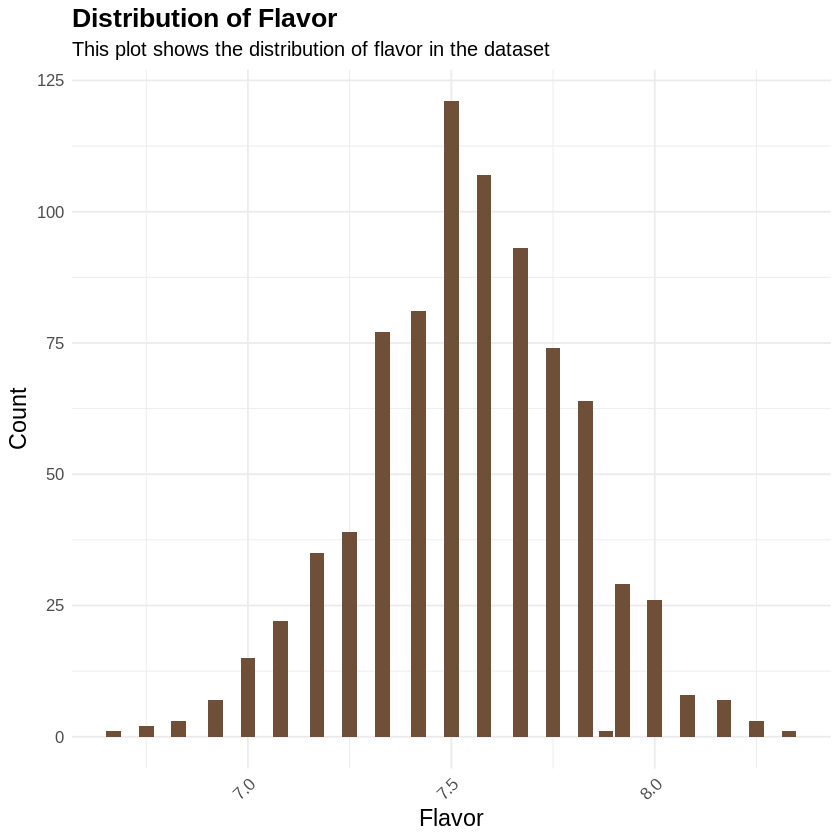

In [ ]:
ggplot(df2, aes(x = Flavor)) +
  geom_bar(fill = "#6F4F37") +
  labs(
    title = "Distribution of Flavor",
    subtitle = "This plot shows the distribution of flavor in the dataset",
    x = "Flavor",
    y = "Count"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 10)
  )

Upon examining the Flavor variable, I observed that its distribution closely resembles a normal distribution, with most values concentrated around the 7 and 8 range. This suggests that, in the dataset of evaluated coffees, the majority tend to fall around a flavor rating of 7.5. Given that the ratings are based on a 1-10 scale, this indicates that the overall quality of the coffee in this dataset is consistently moderate to good.

In [ ]:

numeric_cols <- sapply(df2, is.numeric)
numeric_df2 <- df2[, numeric_cols]

# Calculate unique values for each numeric column
unique_counts <- sapply(numeric_df2, function(x) length(unique(x)))

# Filter columns with more than 1 unique value
cols_gt_1 <- names(unique_counts[unique_counts > 1])


result_df <- numeric_df2[, cols_gt_1]
head(result_df)

,Harvest.Year,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Sweetness,Moisture,Quakers,Minor_Defects,Major_Defects
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
19,2015,8.42,8.25,8.08,8.17,7.92,8.00,10,10,0.10,0,0,0
22,2014,8.08,8.25,8.00,8.17,8.00,8.33,10,10,0.11,0,0,2
23,2012,8.17,8.25,8.17,8.00,7.83,8.17,10,10,0.13,0,0,0
25,2013,8.42,8.17,7.92,8.17,8.33,8.00,10,10,0.11,0,0,1
28,2013,8.42,8.17,8.17,8.17,7.83,7.92,10,10,0.12,0,0,1
30,2015,8.00,8.00,8.00,8.25,8.00,8.17,10,10,0.00,0,0,0


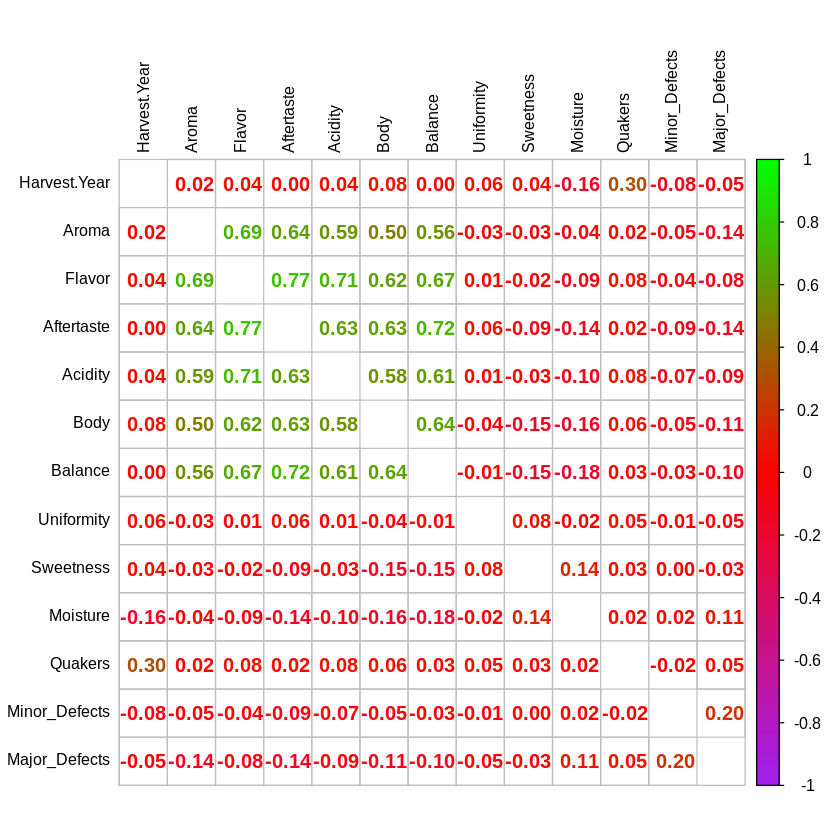

In [ ]:
correlations <- as.matrix(cor(result_df, use = "complete.obs"))

corrplot(correlations, method = "number",
         col = colorRampPalette(c("purple", "red", "green"))(200),
         addCoef.col = "black",
         tl.col = "black",
         tl.cex = 0.8,
         number.cex = 1,
         number.digits = 2,
         diag = FALSE)


After looking at Flavor alone, I wanted to see if there were any obvious relationships I should explore, so I grouped together all the numeric columns in a new dataset for the purpose of creating a correlation heatmap. As we can see here, the variables that have the highest correlation with Flavor are Aroma, Aftertaste, Acidity, Body, and Balance, with the rest falling far behind, either having negative or very low positive values. From this, I can assume that these specific variables are very influential in the coffee reviewers' analysis of the coffee's flavor and likely carry more weight later on when we work on our Flavor regression analysis. This is important to keep in mind.

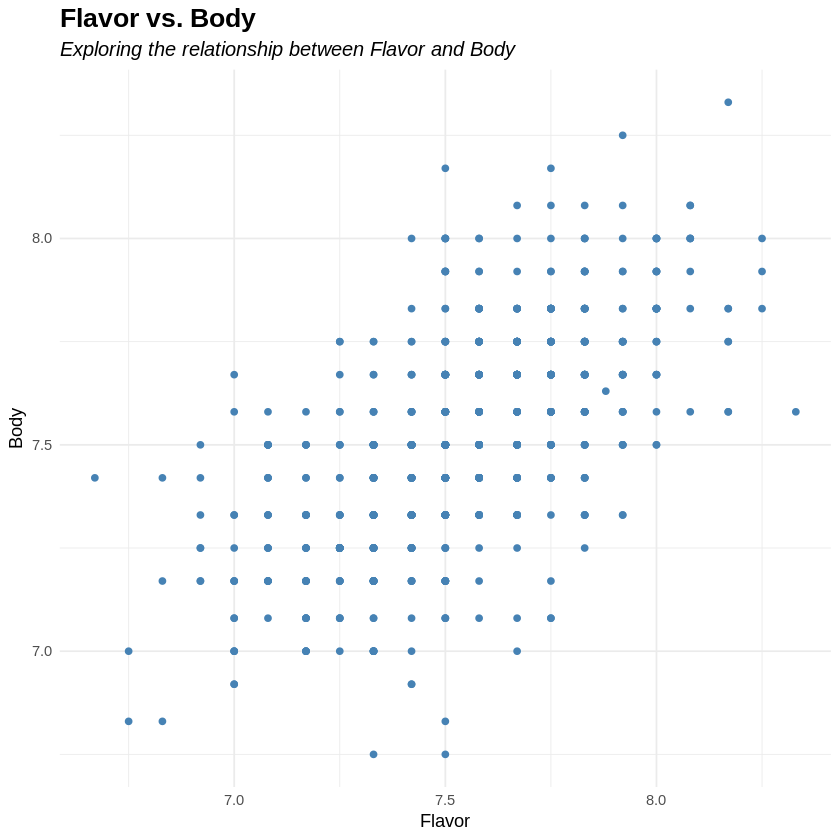

In [ ]:
# Flavor vs. Body
ggplot(df2, aes(x = Flavor, y = Body)) +
  geom_point(color = "steelblue") +
  labs(
    title = "Flavor vs. Body",
    subtitle = "Exploring the relationship between Flavor and Body",
    x = "Flavor",
    y = "Body"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12, face = "italic")
  )

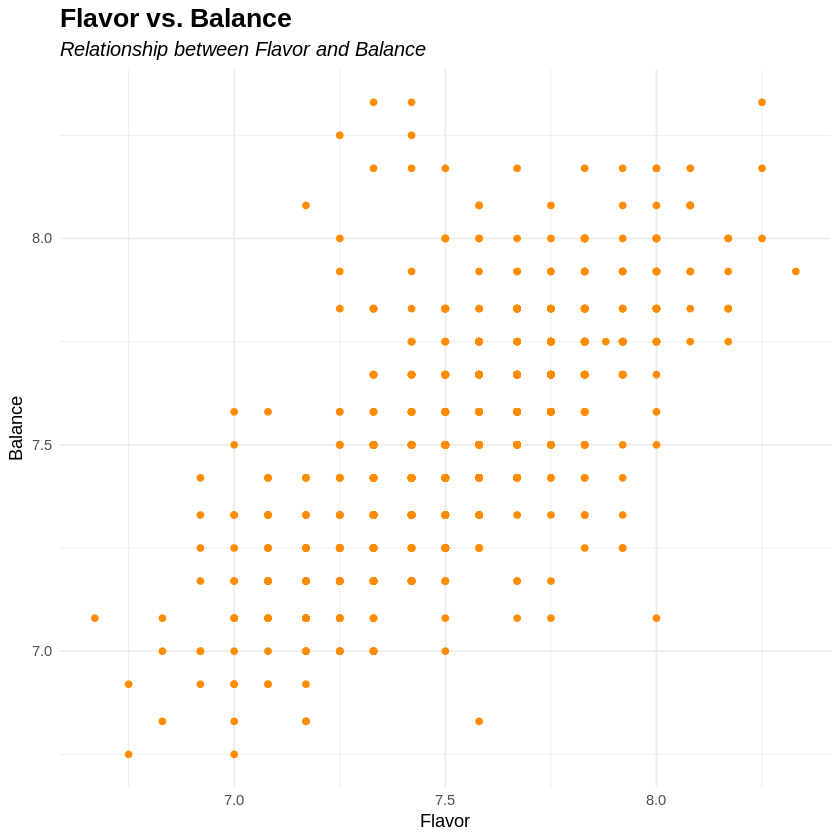

In [ ]:
# Flavor vs. Balance
ggplot(df2, aes(x = Flavor, y = Balance)) +
  geom_point(color = "darkorange") +
  labs(
    title = "Flavor vs. Balance",
    subtitle = "Relationship between Flavor and Balance",
    x = "Flavor",
    y = "Balance"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12, face = "italic")
  )

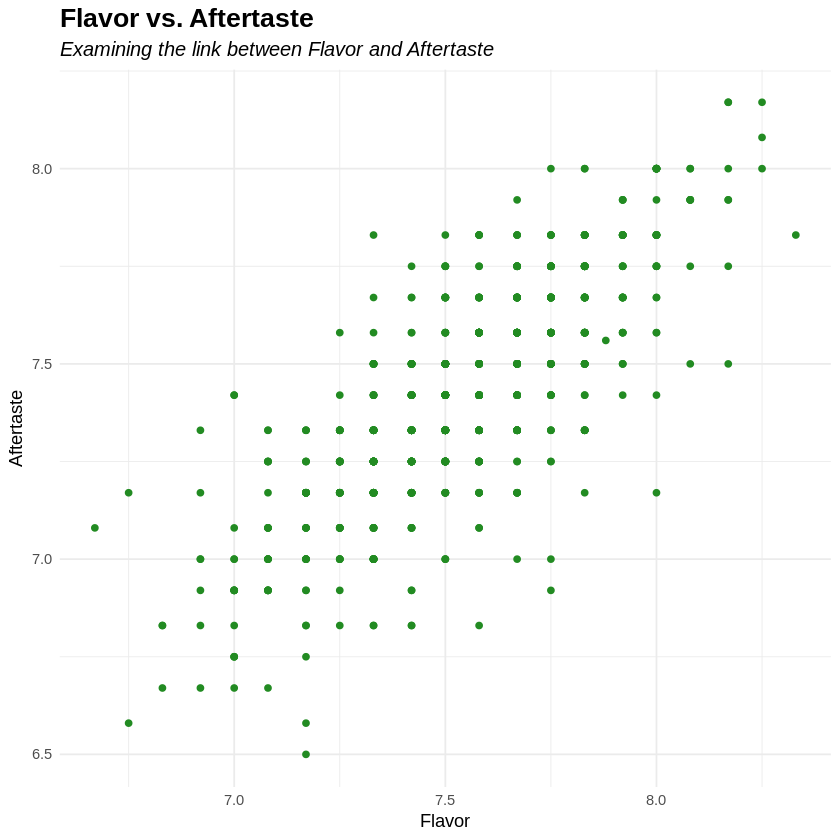

In [ ]:
# Flavor vs. Aftertaste
ggplot(df2, aes(x = Flavor, y = Aftertaste)) +
  geom_point(color = "forestgreen") +
  labs(
    title = "Flavor vs. Aftertaste",
    subtitle = "Examining the link between Flavor and Aftertaste",
    x = "Flavor",
    y = "Aftertaste"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12, face = "italic")
  )

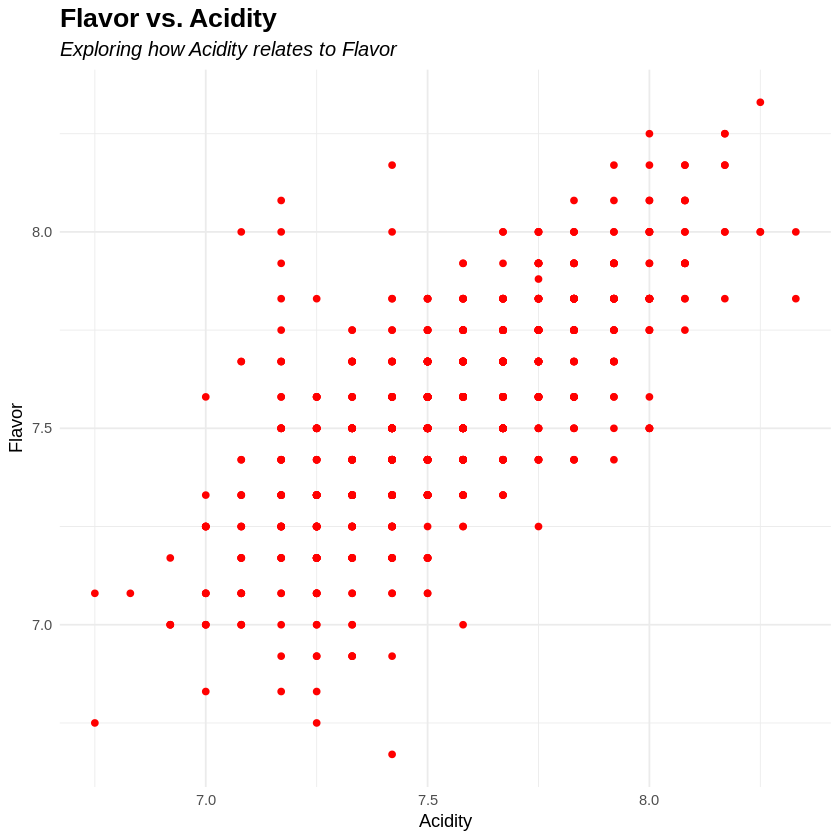

In [ ]:
# Flavor vs. Acidity
ggplot(df2, aes(x = Acidity, y = Flavor)) +
  geom_point(color = "red") +
  labs(
    title = "Flavor vs. Acidity",
    subtitle = "Exploring how Acidity relates to Flavor",
    x = "Acidity",
    y = "Flavor"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12, face = "italic")
  )

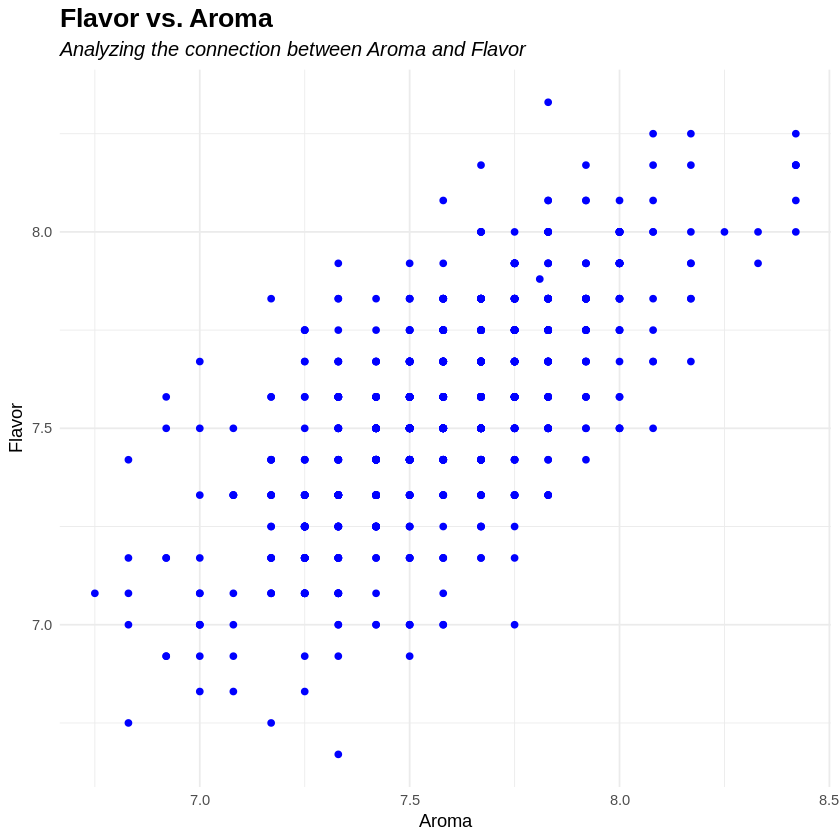

In [ ]:
# Flavor vs. Aroma
ggplot(df2, aes(x = Aroma, y = Flavor)) +
  geom_point(color = "blue") +
  labs(
    title = "Flavor vs. Aroma",
    subtitle = "Analyzing the connection between Aroma and Flavor",
    x = "Aroma",
    y = "Flavor"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12, face = "italic")
  )

While examining each of these plots individually, I noticed similarities in the shapes. The scatter plots appeared almost identical, so I decided to overlay them. To avoid making things too cluttered, I changed the shape of the points for each variable. My goal was to determine if the trend was linear. If it was, I could then consider whether my final model should be linear. I proceeded with this approach to investigate further.

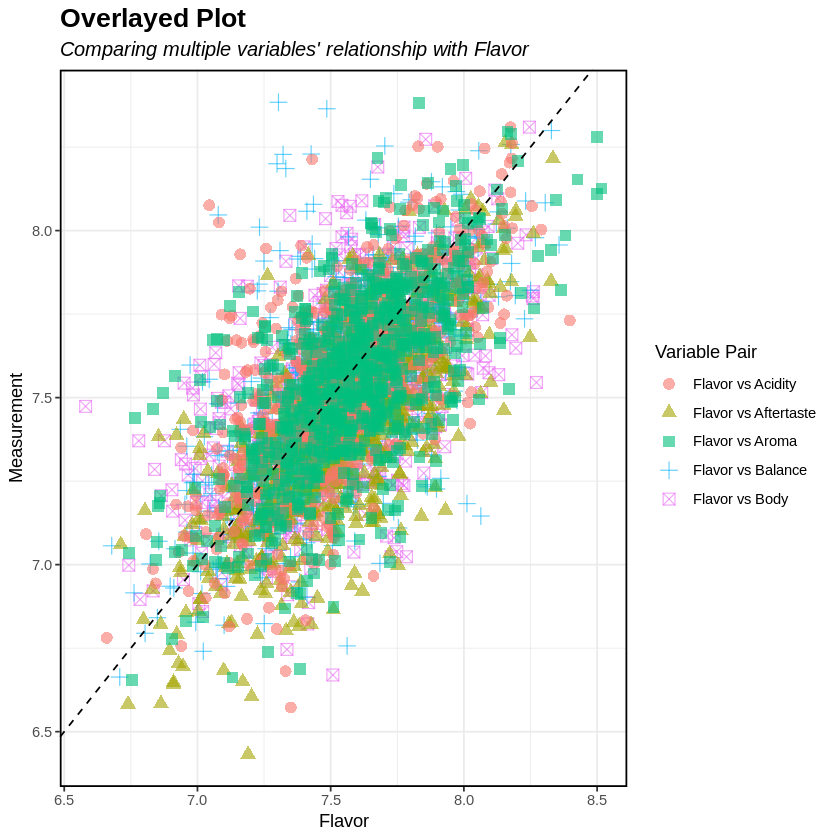

In [ ]:
ggplot(df2) +
  geom_jitter(aes(x = Flavor, y = Body, color = "Flavor vs Body", shape = "Flavor vs Body"), size = 3, alpha = 0.6, width = 0.1, height = 0.1) +
  geom_jitter(aes(x = Flavor, y = Balance, color = "Flavor vs Balance", shape = "Flavor vs Balance"), size = 3, alpha = 0.6, width = 0.1, height = 0.1) +
  geom_jitter(aes(x = Flavor, y = Aftertaste, color = "Flavor vs Aftertaste", shape = "Flavor vs Aftertaste"), size = 3, alpha = 0.6, width = 0.1, height = 0.1) +
  geom_jitter(aes(x = Acidity, y = Flavor, color = "Flavor vs Acidity", shape = "Flavor vs Acidity"), size = 3, alpha = 0.6, width = 0.1, height = 0.1) +
  geom_jitter(aes(x = Aroma, y = Flavor, color = "Flavor vs Aroma", shape = "Flavor vs Aroma"), size = 3, alpha = 0.6, width = 0.1, height = 0.1) +
  geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed") +
  labs(
    title = "Overlayed Plot",
    subtitle = "Comparing multiple variables' relationship with Flavor",
    x = "Flavor",
    y = "Measurement",
    color = "Variable Pair",
    shape = "Variable Pair"
  ) +
  theme_bw() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12, face = "italic"),
    legend.position = "right",
    panel.border = element_rect(color = "black", linewidth = 1)
  )


From my perspective, I believe the pattern is linear, and visually, that’s what I observe. However, to be thorough, I created individual lines for each variable to explore the data further.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


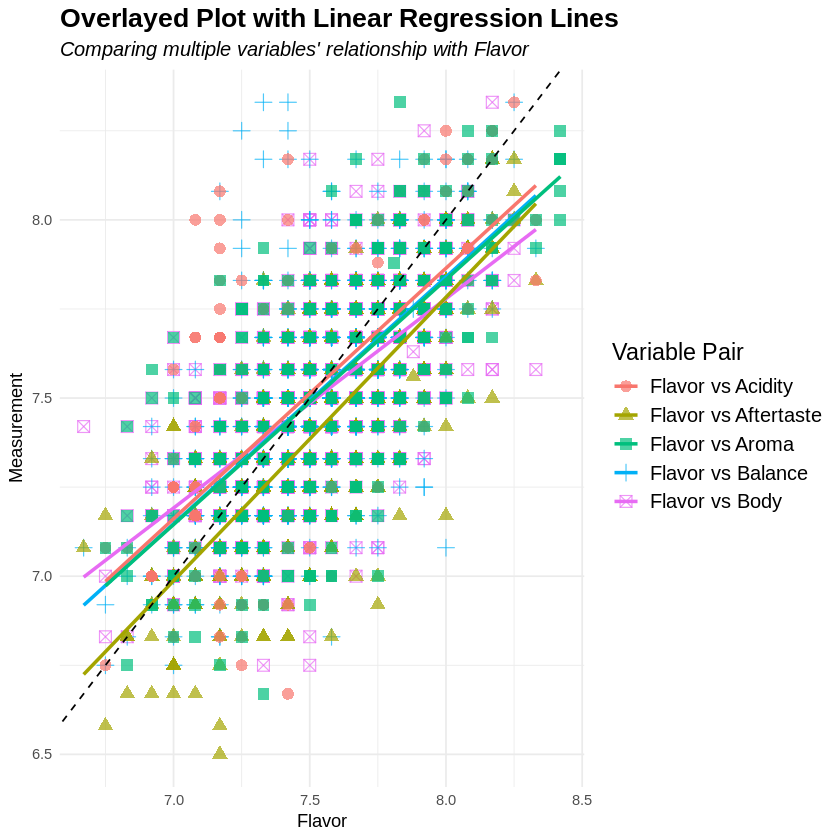

In [ ]:
ggplot(df2) +
  # Points
  geom_point(aes(x = Flavor, y = Body, color = "Flavor vs Body", shape = "Flavor vs Body"), size = 3, alpha = 0.7) +
  geom_point(aes(x = Flavor, y = Balance, color = "Flavor vs Balance", shape = "Flavor vs Balance"), size = 3, alpha = 0.7) +
  geom_point(aes(x = Flavor, y = Aftertaste, color = "Flavor vs Aftertaste", shape = "Flavor vs Aftertaste"), size = 3, alpha = 0.7) +
  geom_point(aes(x = Acidity, y = Flavor, color = "Flavor vs Acidity", shape = "Flavor vs Acidity"), size = 3, alpha = 0.7) +
  geom_point(aes(x = Aroma, y = Flavor, color = "Flavor vs Aroma", shape = "Flavor vs Aroma"), size = 3, alpha = 0.7) +

  # Smooth lines
  geom_smooth(aes(x = Flavor, y = Body, color = "Flavor vs Body", group = "Flavor vs Body"), method = "lm", se = FALSE) +
  geom_smooth(aes(x = Flavor, y = Balance, color = "Flavor vs Balance", group = "Flavor vs Balance"), method = "lm", se = FALSE) +
  geom_smooth(aes(x = Flavor, y = Aftertaste, color = "Flavor vs Aftertaste", group = "Flavor vs Aftertaste"), method = "lm", se = FALSE) +
  geom_smooth(aes(x = Acidity, y = Flavor, color = "Flavor vs Acidity", group = "Flavor vs Acidity"), method = "lm", se = FALSE) +
  geom_smooth(aes(x = Aroma, y = Flavor, color = "Flavor vs Aroma", group = "Flavor vs Aroma"), method = "lm", se = FALSE) +
   geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed") +
  # Labels and theme
  labs(
    title = "Overlayed Plot with Linear Regression Lines",
    subtitle = "Comparing multiple variables' relationship with Flavor",
    x = "Flavor",
    y = "Measurement",
    color = "Variable Pair",
    shape = "Variable Pair"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12, face = "italic"),
    legend.position = "right",
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )


This is honestly far too messy for the audio-visual presentation, but on this report, it indicates that the relationship between these variables and flavor is more than likely linear rather than not. However, the optimal model to accurately represent these relationships has not yet been determined

As a final check for modeling, I was curious if the processing method could have a potential impact on flavor. I assumed that it did but if not, this would be quite shocking.

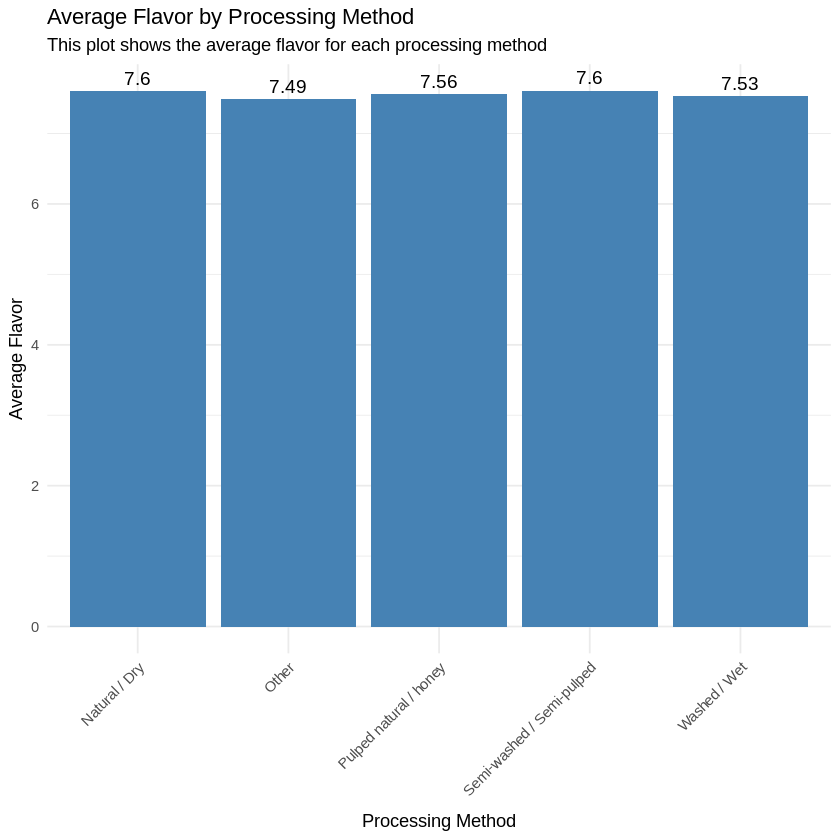

In [ ]:
df2_summary <- df2 %>%
  group_by(Processing.Method) %>%
  summarise(Average.Flavor = mean(Flavor, na.rm = TRUE))
ggplot(df2_summary, aes(x = Processing.Method, y = Average.Flavor)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_text(aes(label = round(Average.Flavor, 2)), vjust = -0.5, size = 4) +
  labs(
    x = "Processing Method",
    y = "Average Flavor",
    title = "Average Flavor by Processing Method",
    subtitle = "This plot shows the average flavor for each processing method"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

I see, it looks like they all have a similar flavor. I was wrong.

###Modeling Relationships

In [ ]:
#Minor Pre-Processing
df3 <- df %>%
  select(Species, Continent.of.Origin, Country.of.Origin, Harvest.Year, Expiration,
         Variety, Color, Processing.Method, Aroma, Flavor, Aftertaste, Acidity,
         Body, Balance, Uniformity, Clean.Cup, Sweetness, Moisture, Quakers,
         Minor_Defects, Major_Defects) %>%
  mutate(
    Species = as.factor(Species),
    Continent.of.Origin = as.factor(Continent.of.Origin),
    Country.of.Origin = as.factor(Country.of.Origin),
    Variety = as.factor(Variety),
    Color = as.factor(Color),
    Processing.Method = as.factor(Processing.Method),
    Expiration = as.Date(Expiration, format = "%m/%d/%y")  # Convert Expiration to Date type
  )

df3 <- na.omit(df3)

df3 <- df3 %>%
  mutate_if(is.factor, as.character) %>%  # Convert factors to characters (for dummy conversion)
  model.matrix(~ . - 1, data = .) %>%     # Create dummy variables (remove intercept)
  data.frame()                           # Convert back to data frame

Here I created a new version of the dataset I have been working with that includes only relevant columns. I converted some to factor (categorical) form and afterward encoded them for regression.

In [ ]:
# drop the min(df3$Flavor) because there was an outlier messing up the models-
  #-significantly

min_flavor <- min(df3$Flavor)
min_flavor
df3 <- df3[df3$Flavor != min_flavor, ]
min_flavor <- min(df3$Flavor)
min_flavor

[1] 0

[1] 6.08

Here I was forced to drop the minimum Flavor entry because It skewed my data greatly as it had a value of 0.

I split my data radnomaly and allocated 80% of it to training and the remaining 20% to testing for my data sets.

In [ ]:
set.seed(123)
train_index <- sample(1:nrow(df3), 0.8 * nrow(df3))  # 80% of data for training
train_data <- df3[train_index, ]  # Training data
test_data <- df3[-train_index, ]  # Testing data

cat("Training data size: ", nrow(train_data), " rows\n")
cat("Testing data size: ", nrow(test_data), " rows\n")

target_variable <- "Flavor"

# Train and test data for predictors and response
train_features <- train_data[, setdiff(names(train_data), target_variable)]
test_features <- test_data[, setdiff(names(test_data), target_variable)]

train_target <- train_data[[target_variable]]
test_target <- test_data[[target_variable]]

Training data size:  1021  rows
Testing data size:  256  rows


SInce I had observed a visual linear relationship I started out with a linear model.

Warning message in predict.lm(lm_model, newdata = test_data):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


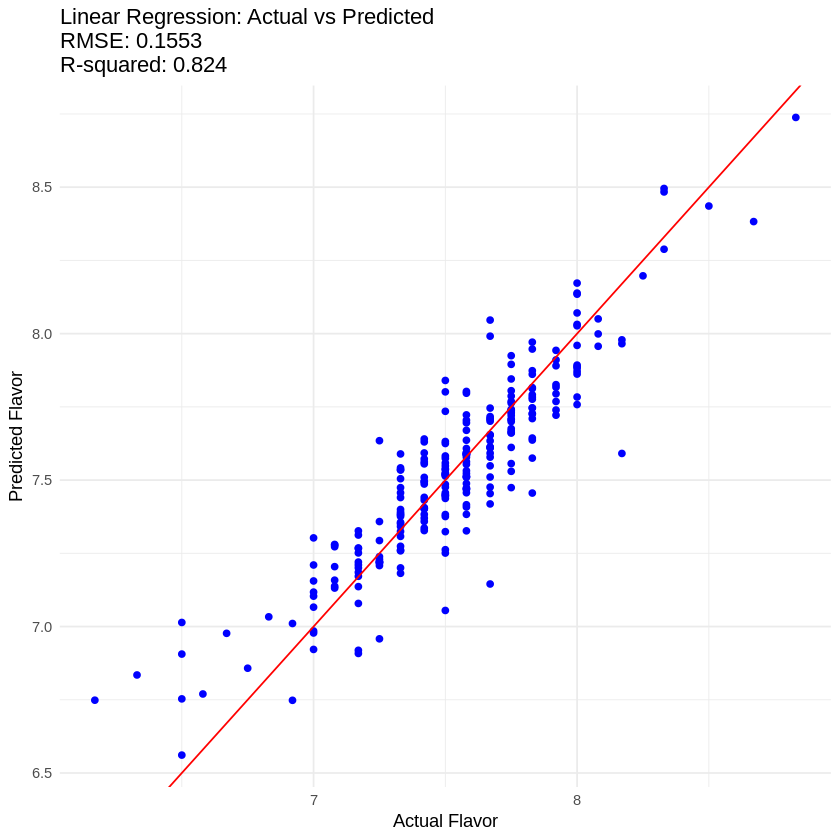

In [ ]:
lm_model <- lm(Flavor ~ ., data = train_data)
lm_predictions <- predict(lm_model, newdata = test_data)

lm_rmse <- sqrt(mean((test_target - lm_predictions)^2))
lm_rsq <- 1 - sum((test_target - lm_predictions)^2) / sum((test_target - mean(test_target))^2)

ggplot(data.frame(Actual = test_target, Predicted = lm_predictions), aes(x = Actual, y = Predicted)) +
  geom_point(color = 'blue') +
  geom_abline(slope = 1, intercept = 0, color = 'red') +
  labs(title = paste('Linear Regression: Actual vs Predicted\nRMSE:', round(lm_rmse, 4),
                     '\nR-squared:', round(lm_rsq, 4)),
       x = 'Actual Flavor',
       y = 'Predicted Flavor') +
  theme_minimal()

Although we see clear gaps in the x-variable data, this is only due to rounding. Overall, this looks like an excellent fit, with some variation toward the start and end of the plot. The linear regression model captures the general trend well, indicating a strong relationship between the predictors and the target variable. However, the slight deviations at the extremes suggest that there may be additional factors influencing the target variable, which the linear model is not capturing. These discrepancies could be due to outliers, unaccounted variables, or non-linear relationships that a more complex model might better address. Despite this, the R-squared value suggests that the model explains a significant portion of the variance in the data, highlighting its effectiveness for this particular analysis.

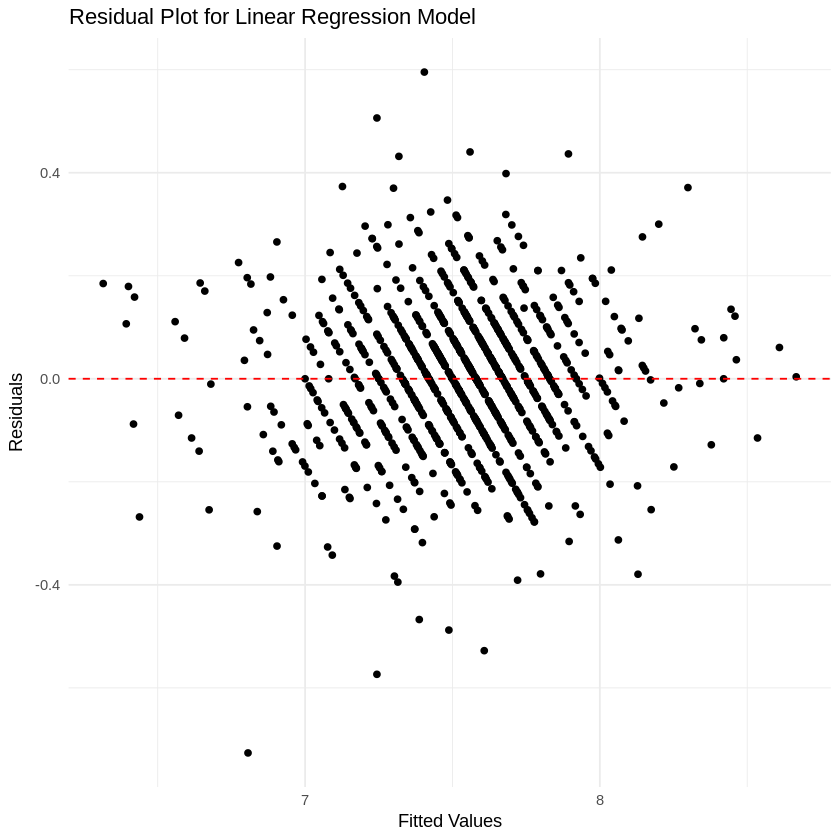

In [ ]:

lm_residuals <- residuals(lm_model)

ggplot(data.frame(Fitted = lm_model$fitted.values, Residuals = lm_residuals),
       aes(x = Fitted, y = Residuals)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residual Plot for Linear Regression Model",
       x = "Fitted Values",
       y = "Residuals") +
  theme_minimal()

My linear regression residual plot is mostly rndnom, which is great news. I see a couple outlier that are wroth looking over but not anything too significant.

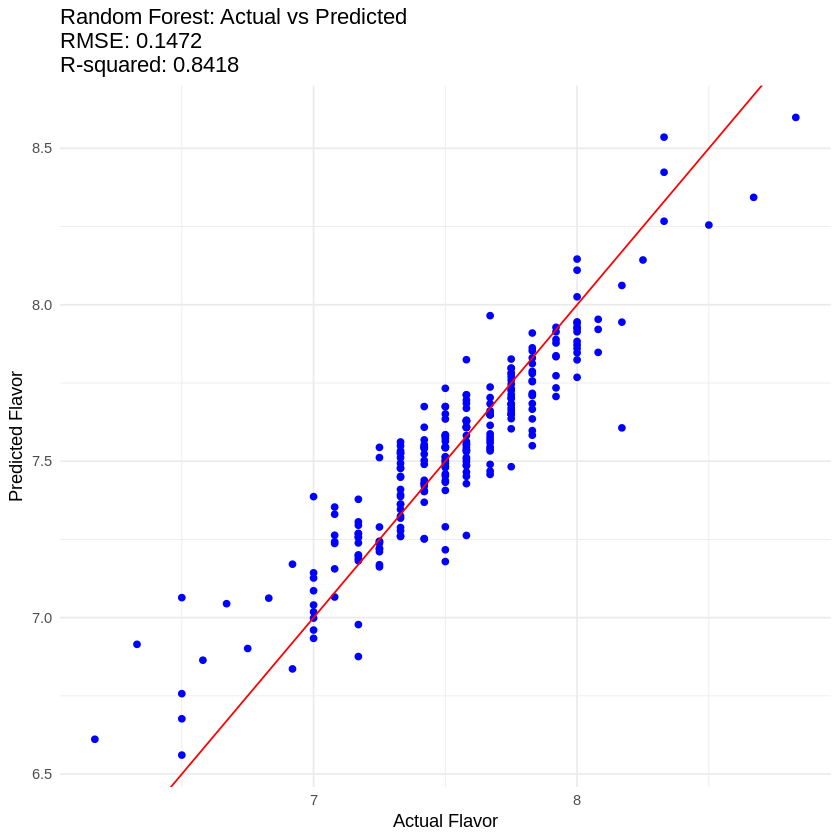

In [ ]:
rf_model <- randomForest(Flavor ~ ., data = train_data)
rf_predictions <- predict(rf_model, newdata = test_data)

rf_rmse <- sqrt(mean((test_target - rf_predictions)^2))
rf_rsq <- 1 - sum((test_target - rf_predictions)^2) / sum((test_target - mean(test_target))^2)
ggplot(data.frame(Actual = test_target, Predicted = rf_predictions), aes(x = Actual, y = Predicted)) +
  geom_point(color = 'blue') +
  geom_abline(slope = 1, intercept = 0, color = 'red') +
  labs(title = paste('Random Forest: Actual vs Predicted\nRMSE:', round(rf_rmse, 4),
                     '\nR-squared:', round(rf_rsq, 4)),
       x = 'Actual Flavor',
       y = 'Predicted Flavor') +
  theme_minimal()

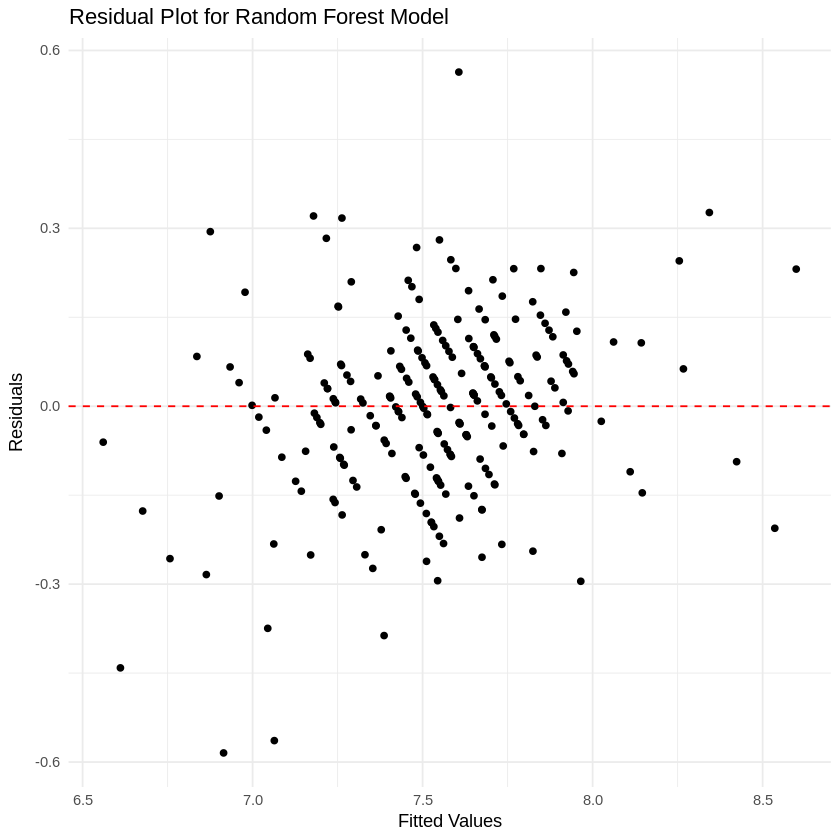

In [ ]:

rf_residuals <- test_target - rf_predictions

ggplot(data.frame(Fitted = rf_predictions, Residuals = rf_residuals),
       aes(x = Fitted, y = Residuals)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residual Plot for Random Forest Model",
       x = "Fitted Values",
       y = "Residuals") +
  theme_minimal()

The residuals similar to the linear model also are random with a couple outliers but the r-squared value here indicate the the Random Forest Model preformed better overall.

In [ ]:
gbm_model <- gbm(Flavor ~ ., data = train_data, distribution = "gaussian", n.trees = 100, interaction.depth = 5)
gbm_predictions <- predict(gbm_model, newdata = test_data, n.trees = 100)
gbm_rmse <- sqrt(mean((test_target - gbm_predictions)^2))
gbm_rsq <- 1 - sum((test_target - gbm_predictions)^2) / sum((test_target - mean(test_target))^2)

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 7: Country.of.OriginBurundi has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 60: VarietyPeaberry has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 65: VarietySulawesi has no variation.”


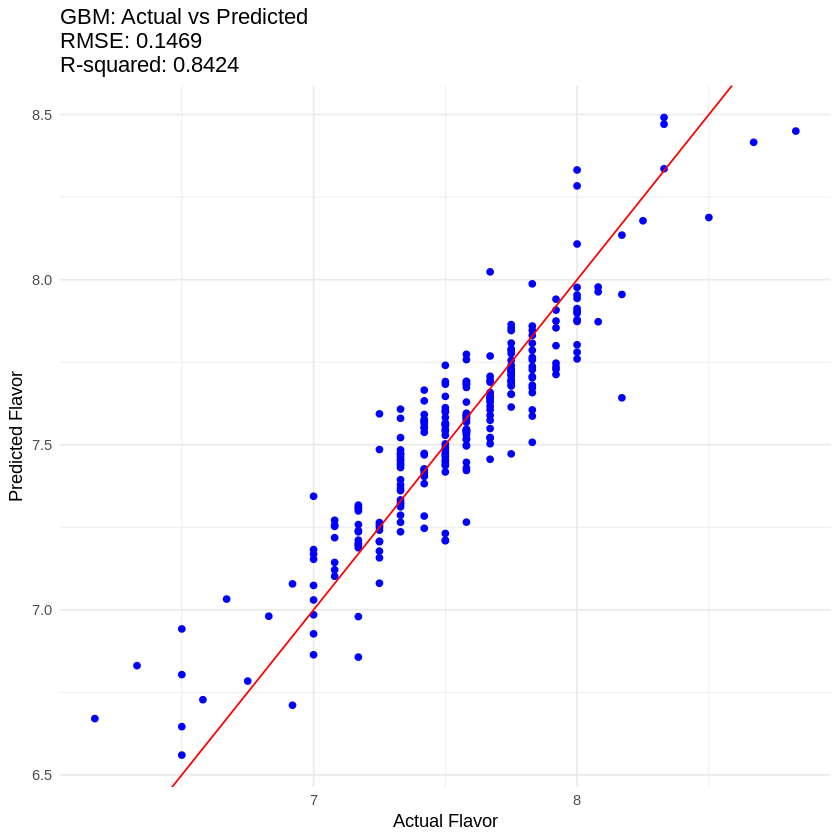

In [ ]:
ggplot(data.frame(Actual = test_target, Predicted = gbm_predictions), aes(x = Actual, y = Predicted)) +
  geom_point(color = 'blue') +
  geom_abline(slope = 1, intercept = 0, color = 'red') +
  labs(title = paste('GBM: Actual vs Predicted\nRMSE:', round(gbm_rmse, 4),
                     '\nR-squared:', round(gbm_rsq, 4)),
       x = 'Actual Flavor',
       y = 'Predicted Flavor') +
  theme_minimal()

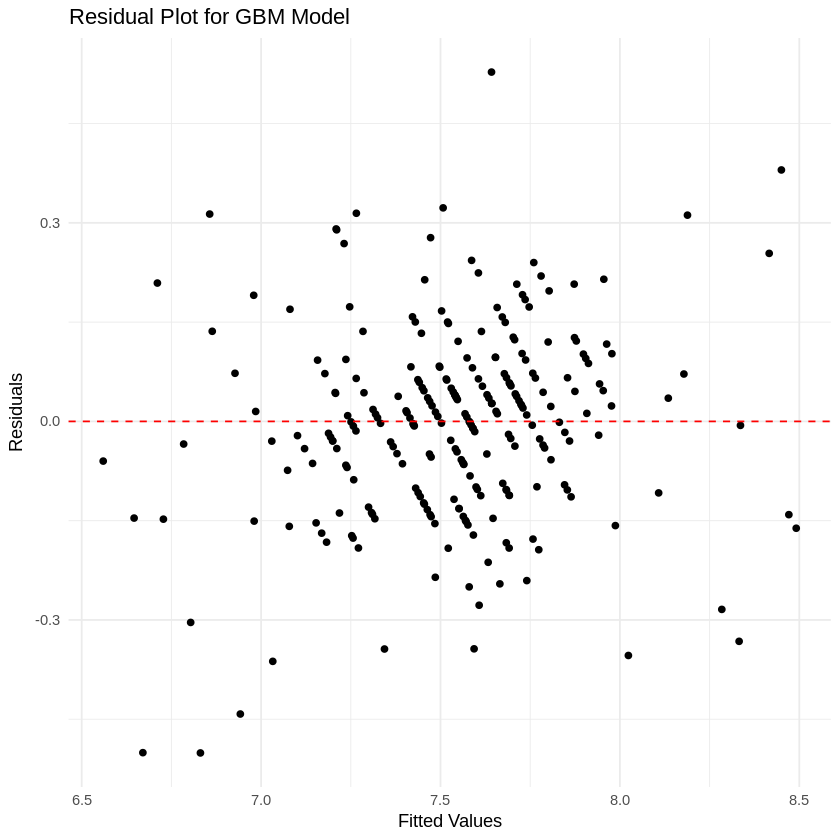

In [ ]:
gbm_residuals <- test_target - gbm_predictions

ggplot(data.frame(Fitted = gbm_predictions, Residuals = gbm_residuals),
       aes(x = Fitted, y = Residuals)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residual Plot for GBM Model",
       x = "Fitted Values",
       y = "Residuals") +
  theme_minimal()

After evaluating the models, I found that the Gradient Boosting model provides a better fit, with a higher R-squared and lower MSE, making it the best model. This is particularly interesting, as I initially observed a linear pattern in the data before modeling any relationships. It suggests that the Gradient Boosting model may be better at capturing more complex patterns in the data that the linear regression model could not detect.

In [ ]:
#RMSE and R-Squared of all 3

cat('\n')
cat(" The RMSE for the base Random Forest model is: ",rf_rmse)
cat(" The R-Squared value for the base Random Forest model is:",rf_rsq)
cat('\n')
cat(" The RMSE for the base Linear model is: ",lm_rmse)
cat(" The R-Squared value for the base Linear model is:",lm_rsq)
cat('\n')
cat(" The RMSE for the base GBM model is: ",gbm_rmse)
cat(" The R-Squared value for the base GBM model is:",gbm_rsq)


 The RMSE for the base Random Forest model is:  0.1472079 The R-Squared value for the base Random Forest model is: 0.841848
 The RMSE for the base Linear model is:  0.1553068 The R-Squared value for the base Linear model is: 0.8239674
 The RMSE for the base GBM model is:  0.1469335 The R-Squared value for the base GBM model is: 0.842437

In [ ]:
gbm_importance <- summary(gbm_model, plotit = FALSE)
gbm_importance_top5 <- gbm_importance[1:5, ]
gbm_importance_top5$Percentage <- (gbm_importance_top5$rel.inf / sum(gbm_importance_top5$rel.inf)) * 100


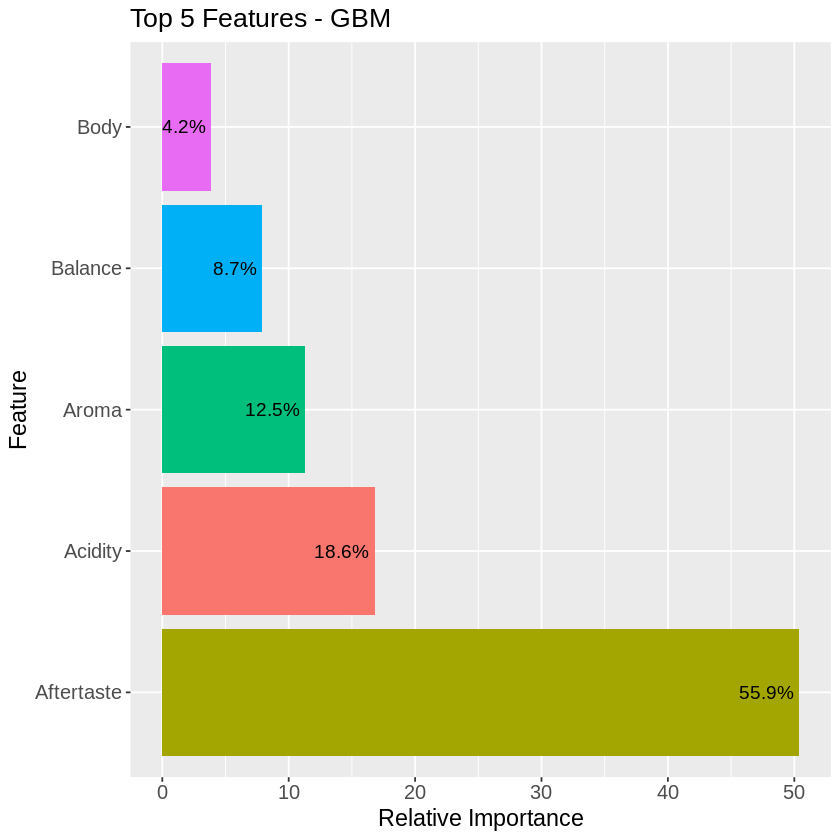

In [ ]:
ggplot(gbm_importance_top5, aes(x = reorder(var, -rel.inf), y = rel.inf, fill = var)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  geom_text(aes(label = paste0(round(Percentage, 1), "%")),
            hjust = 1.1, color = "black", size = 4) +
  labs(title = "Top 5 Features - GBM", x = "Feature", y = "Relative Importance") +
  theme(legend.position = "none") +
  theme(axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14),
        plot.title = element_text(size = 16))

Interestingly enough, the exact same variables that we plotted earlier for our correlation plot are the ones identified by our model as the most important. Aftertaste contributes about 56% of the model's data, followed by Acidity (18.6%), Aroma (12.5%), Balance (8.7%), and Body (4.2%).

## Final Analysis and Practical Impacts

We have found that
Among the models tested, Gradient Boosting (GBM) performed the best with the lowest RMSE and the highest R-squared, indicating it is the most suitable for capturing the nuances of these relationships. The success of this model indicates that the GBM was superior in capturing subtle non-linear patterns that exist in the data which simpler models could not capture.
there is a clear relationship between the quality attributes (Aftertaste, Acidity, Aroma, Balance, and Body) and the Flavor score, with Aftertaste being the most critical factor,
contributing 56% to the model's predictive power.
Aftertaste and Acidity are considered important under the top 5 points to the idea that sensory evaluation plays a major role in flavor quality.


Practically the people who benefit most from this data are coffee producers and farmers, who can turn their efforts to improve more impactful factors such as Afertase, Acidity, Armoma Banalcen, and Body during cultivation harvesting, and processing with various techniques.

Quality control teams at major coffee brands can use this information to better understand key flavor drivers and guide quality assurance efforts and resource allocation to maintain high standards.

Coffee Roasters and Blenders can use these findings to create blends that are more desirable to consumers based on flavor profile and Specialty coffee buyers and retailers can refine their selection criteria, marking strategies, and training programs for enhanced flavor.

My recommendations based on our research would be to invest in the best training techniques and practices that enhance aftertaste and acidity like optimal fermentation and drying.

I'd also point out the importance of marketing. Highlighting Aftertaste as a selling point when promoting premium coffees might be a good idea.

I would also encourage experimentation with blends or variants that enhance the body and balance to create new flavor profiles using the Gradient Boosting Model as a tool for predicting flavor quality during quality control and research trials.

Overall though I would say further research to explore the effects of untested factors is most important to see what specifically can one take action in to enhance body, balance, and Aroma.

In [ ]:
system("jupyter nbconvert --to html /content/MembrenoFinalMath331.ipynb")